In [143]:
from copy import deepcopy
import cobra
from process_bigraph import Composite
from process_bigraph import ProcessTypes
from process_bigraph.emitter import gather_emitter_results

from cdFBA import register_types
from cdFBA.processes.dfba import dFBA, UpdateEnvironment, StaticConcentration, Injector, WaveFunction

from cdFBA.utils import make_cdfba_composite, get_injector_spec, get_wave_spec, get_static_spec, set_concentration, set_kinetics

from pathlib import Path
from cobra.io import load_json_model, save_json_model, load_matlab_model, save_matlab_model, read_sbml_model, write_sbml_model
import logging

from matplotlib import pyplot as plt
from pprint import pprint

import cProfile
import pstats
import io


In [144]:
#Load E. coli model
y_pestis_no_gapA = cobra.io.load_model("iPC815")
#Copy model
y_pestis_d_glu_ex = y_pestis_no_gapA.copy()

In [145]:
# check("gal_c", y_pestis_no_gapA, y_pestis_no_gapA.optimize)

In [146]:
for rxn in y_pestis_no_gapA.reactions:
    if rxn.name == "D-Glucose exchange":
        print(rxn)

EX_glc__D_e: glc__D_e <=> 


In [147]:
# Knock out acyl carrier protein
y_pestis_no_gapA.genes.YPO2157.knock_out()
# #Knock out reaction
y_pestis_d_glu_ex.reactions.EX_glc__D_e.knock_out() # no carbon supply during glycolysis

In [148]:
# #save models in SBML format
write_sbml_model(y_pestis_no_gapA, "/Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/Vivarium/cdFBA-main/Notebooks/y_pestis_no_gapA.xml")
write_sbml_model(y_pestis_d_glu_ex, "/Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/Vivarium/cdFBA-main/Notebooks/y_pestis_d_glu_ex.xml")

In [149]:
for g in y_pestis_no_gapA.genes:
    if g.name == "gapA":
        print(g.id)

YPO2157


In [150]:
## Find associated exchange reactions
# y_pestis_no_gapA.genes.get_by_id('YPO2157').reactions
# for rxn in y_pestis_no_gapA.reactions:
#     if rxn.name == "D-Glucose exchange":
#         print(rxn)

In [151]:
#create model dictionary
model_dict = {
    'deltaGapA':'/Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/Vivarium/cdFBA-main/Notebooks/y_pestis_d_glu_ex.xml',
    'deltaEX_glc__D_e':'/Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/Vivarium/cdFBA-main/Notebooks/y_pestis_d_glu_ex.xml'
}
#list exchange reactions
exchanges = ['EX_glc__D_e', 'GALt2pp'] # first is reaction associated with D-glucose, second is D-galactose transport
#set volume
volume=2
# define a single dFBA model
spec = make_cdfba_composite(model_dict, medium_type=None, exchanges=exchanges, volume=volume, interval=0.1)
#print spec
pprint(spec)

{'Shared Environment': {'concentrations': {'D-Galactose': 10.0,
                                           'D-Glucose': 10.0,
                                           'deltaEX_glc__D_e': 0.25,
                                           'deltaGapA': 0.25},
                        'counts': {'D-Galactose': 20,
                                   'D-Glucose': 20,
                                   'deltaEX_glc__D_e': 0.5,
                                   'deltaGapA': 0.5},
                        'volume': 2},
 'Species': {'deltaEX_glc__D_e': {'_type': 'process',
                                  'address': 'local:dFBA',
                                  'config': {'bounds': {},
                                             'changes': {'bounds': {},
                                                         'gene_knockout': [],
                                                         'kinetics': {},
                                                         'reaction_knockout': []},
       

In [152]:
#Set reaction bounds
spec['Species']['deltaGapA']['config']['bounds'] = {
            "EX_glc__D_e": {"lower": -2, "upper": None},
            "GALt2pp": {"lower": 1, "upper": 1},
        }
spec['Species']['deltaEX_glc__D_e']['config']['bounds'] = {
            "EX_glc__D_e": {"lower": -2, "upper": None},
            "GALt2pp": {"lower": 1, "upper": 1},
        }

In [153]:
#set external substrate concentrations
concentrations = {
    'D-Galactose': 0,
}
set_concentration(spec, concentrations)

In [154]:
#set kinetics
kinetics = {
    'D-Galactose': (0.5, 5)
}
for species in model_dict.keys():
    set_kinetics(species, spec, kinetics)
pprint(spec)

{'Shared Environment': {'concentrations': {'D-Galactose': 0,
                                           'D-Glucose': 10.0,
                                           'deltaEX_glc__D_e': 0.25,
                                           'deltaGapA': 0.25},
                        'counts': {'D-Galactose': 0,
                                   'D-Glucose': 20,
                                   'deltaEX_glc__D_e': 0.5,
                                   'deltaGapA': 0.5},
                        'volume': 2},
 'Species': {'deltaEX_glc__D_e': {'_type': 'process',
                                  'address': 'local:dFBA',
                                  'config': {'bounds': {'EX_glc__D_e': {'lower': -2,
                                                                        'upper': None},
                                                        'GALt2pp': {'lower': 1,
                                                                    'upper': 1}},
                                        

In [155]:
#set emitter specs
spec['emitter'] = {
        "_type": "step",
        "address": "local:ram-emitter",
        "config": {
            "emit": {
                "shared_environment": "any",
                "global_time": "any",
            }
        },
        "inputs": {
            "shared_environment": ["Shared Environment"],
            "global_time": ["global_time"]
        }
    }

In [156]:
#create the core object
core = ProcessTypes()
#register data types
core = register_types(core)
#register all processes and steps
core.register_process('dFBA', dFBA)
core.register_process('UpdateEnvironment', UpdateEnvironment)
core.register_process('StaticConcentration', StaticConcentration)
core.register_process('WaveFunction', WaveFunction)
core.register_process('Injector', Injector)

In [157]:
#create simulation composite
sim = Composite({
        "state": spec,
        },
        core=core
    )

In [160]:
#run simulation
sim.run(20)

ValueError: The lower bound must be less than or equal to the upper bound (4.83712559692712e-09 <= 0.0).

In [163]:
try:
    sim.run(20)
except ValueError as e:
    import traceback
    traceback.print_exc()

Traceback (most recent call last):
  File "/var/folders/83/2fn1zt090m956h7gkwysmm980000gn/T/ipykernel_51038/3080917018.py", line 2, in <module>
    sim.run(20)
  File "/Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/rotation.venv/lib/python3.12/site-packages/process_bigraph/composite.py", line 1304, in run
    full_step = self.run_process(
                ^^^^^^^^^^^^^^^^^
  File "/Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/rotation.venv/lib/python3.12/site-packages/process_bigraph/composite.py", line 1397, in run_process
    update = self.process_update(path, process, state, process_interval)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/rotation.venv/lib/python3.12/site-packages/process_bigraph/composite.py", line 1439, in process_update
    update = process['instance'].invoke(clean_state, interval)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [164]:
#gather results
results = gather_emitter_results(sim)[('emitter',)]

In [165]:
#extract time-series data
timepoints = []
for timepoint in results:
    time = timepoint.pop('global_time')
    timepoints.append(time)
env = [timepoint['shared_environment']['concentrations'] for timepoint in results]
env_combined = {}
for d in env:
    for key, value in d.items():
        if key not in env_combined:
            env_combined[key] = []
        env_combined[key].append(value)

In [166]:
results

[{'shared_environment': {'concentrations': {'D-Glucose': 10.0,
    'D-Galactose': 0.0,
    'deltaGapA': 0.25,
    'deltaEX_glc__D_e': 0.25},
   'counts': {'D-Glucose': 20.0,
    'D-Galactose': 0.0,
    'deltaGapA': 0.5,
    'deltaEX_glc__D_e': 0.5},
   'volume': 2.0}},
 {'shared_environment': {'counts': {'D-Glucose': 20.0,
    'D-Galactose': 0.0,
    'deltaGapA': 0.5,
    'deltaEX_glc__D_e': 0.5},
   'concentrations': {'D-Glucose': 10.0,
    'D-Galactose': 0.0,
    'deltaGapA': 0.25,
    'deltaEX_glc__D_e': 0.25},
   'volume': 2.0}},
 {'shared_environment': {'counts': {'D-Glucose': np.float64(19.80952380952381),
    'D-Galactose': np.float64(0.0),
    'deltaGapA': np.float64(0.5141779190607415),
    'deltaEX_glc__D_e': np.float64(0.5141779190607415)},
   'concentrations': {'D-Glucose': np.float64(9.904761904761905),
    'D-Galactose': np.float64(0.0),
    'deltaGapA': np.float64(0.25708895953037075),
    'deltaEX_glc__D_e': np.float64(0.25708895953037075)},
   'volume': 2.0}},
 {'share

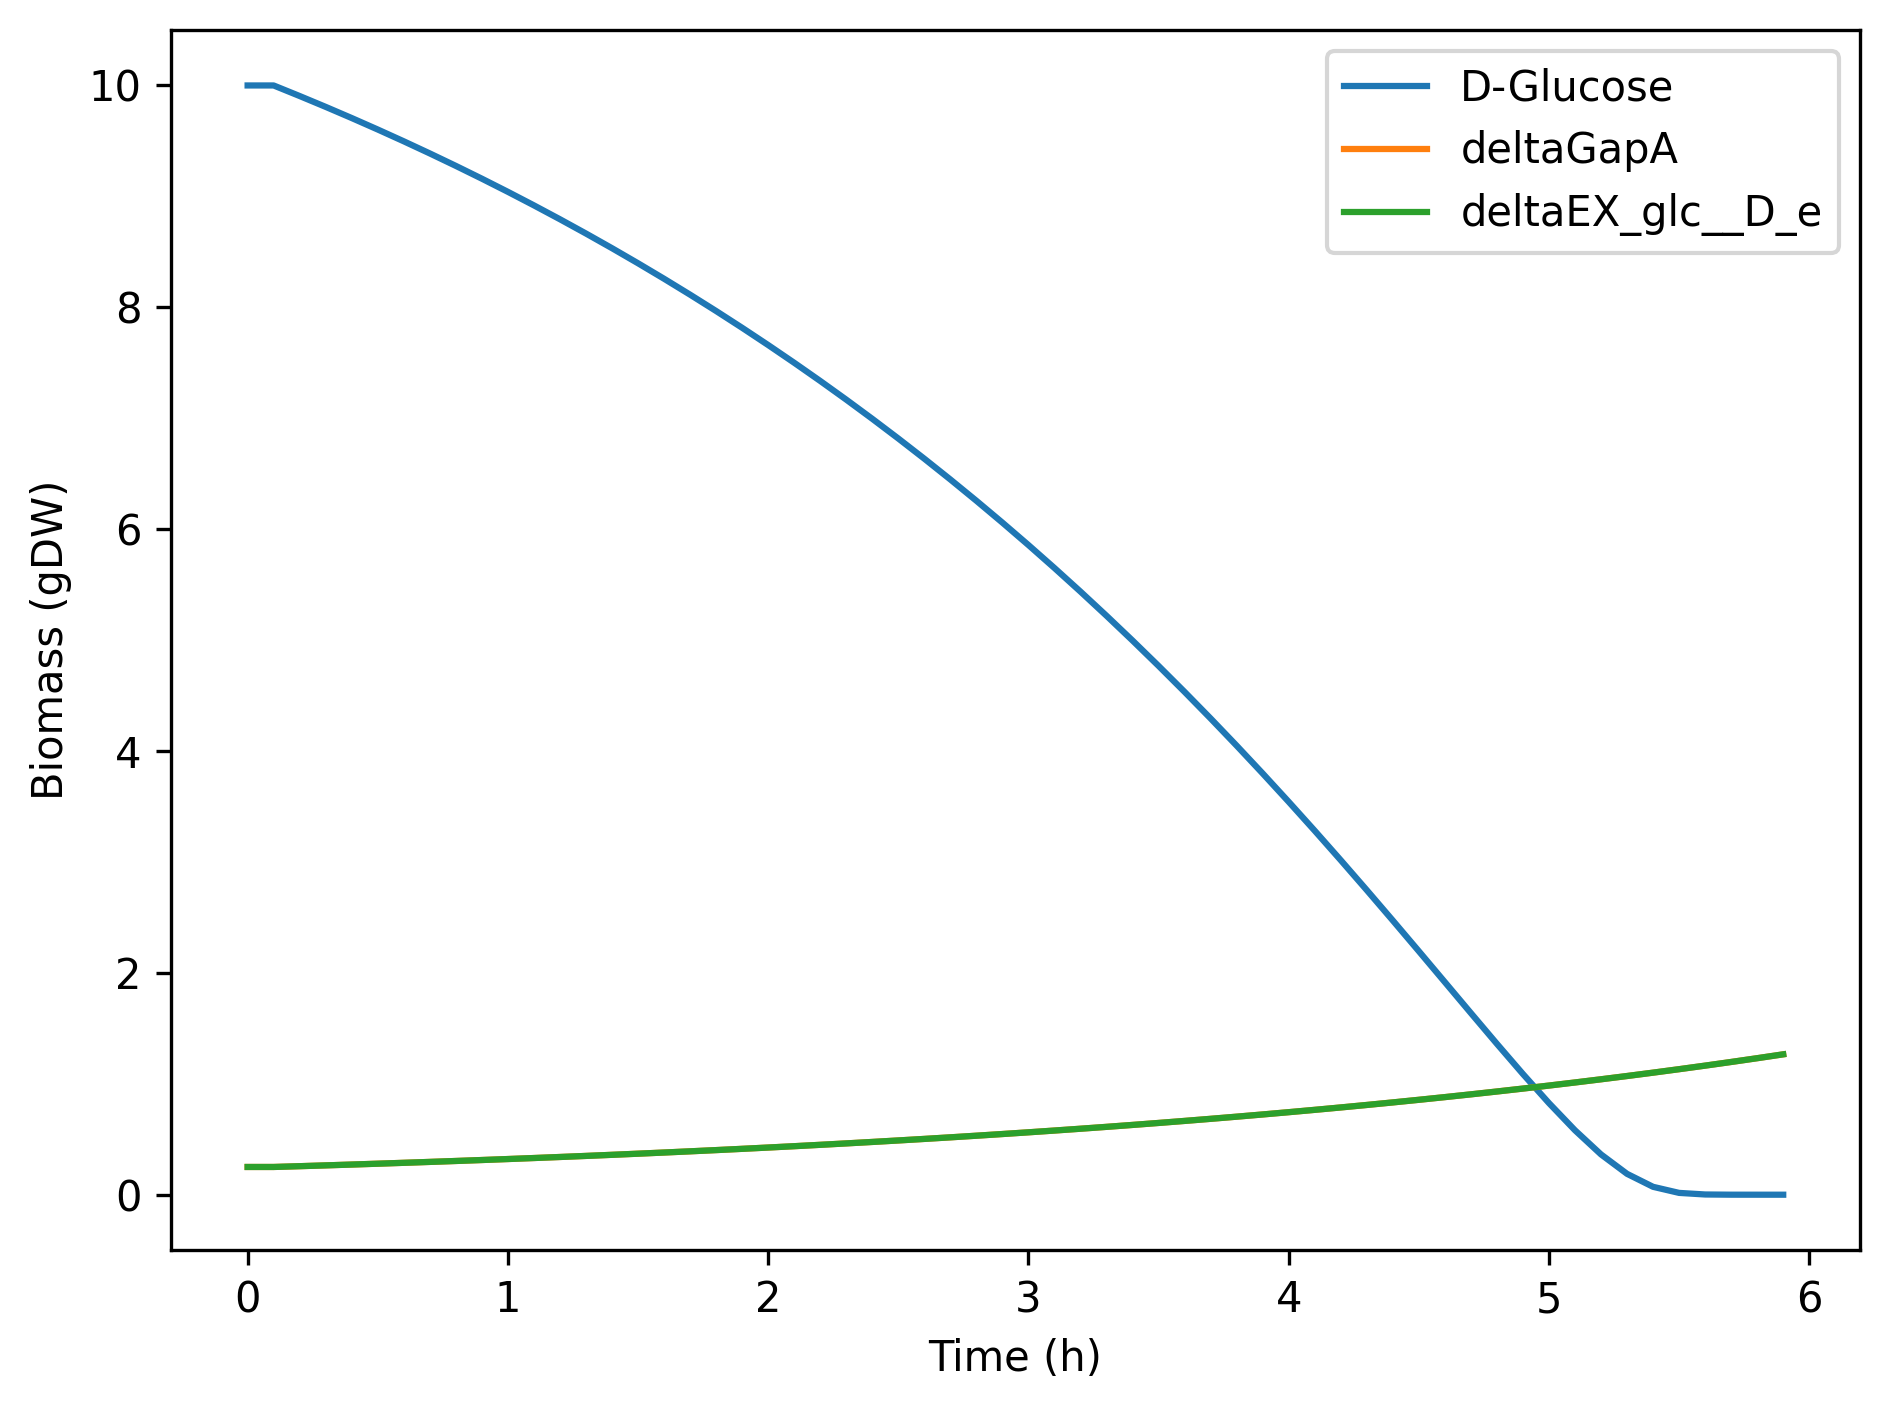

In [168]:
#plot results for biomass
fig, ax = plt.subplots(dpi=300)
for key, value in env_combined.items():
    if key not in ['Lactose C12H22O11', 'D-Galactose']:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time (h)')
plt.ylabel('Biomass (gDW)')
plt.legend()
plt.tight_layout()
plt.show()

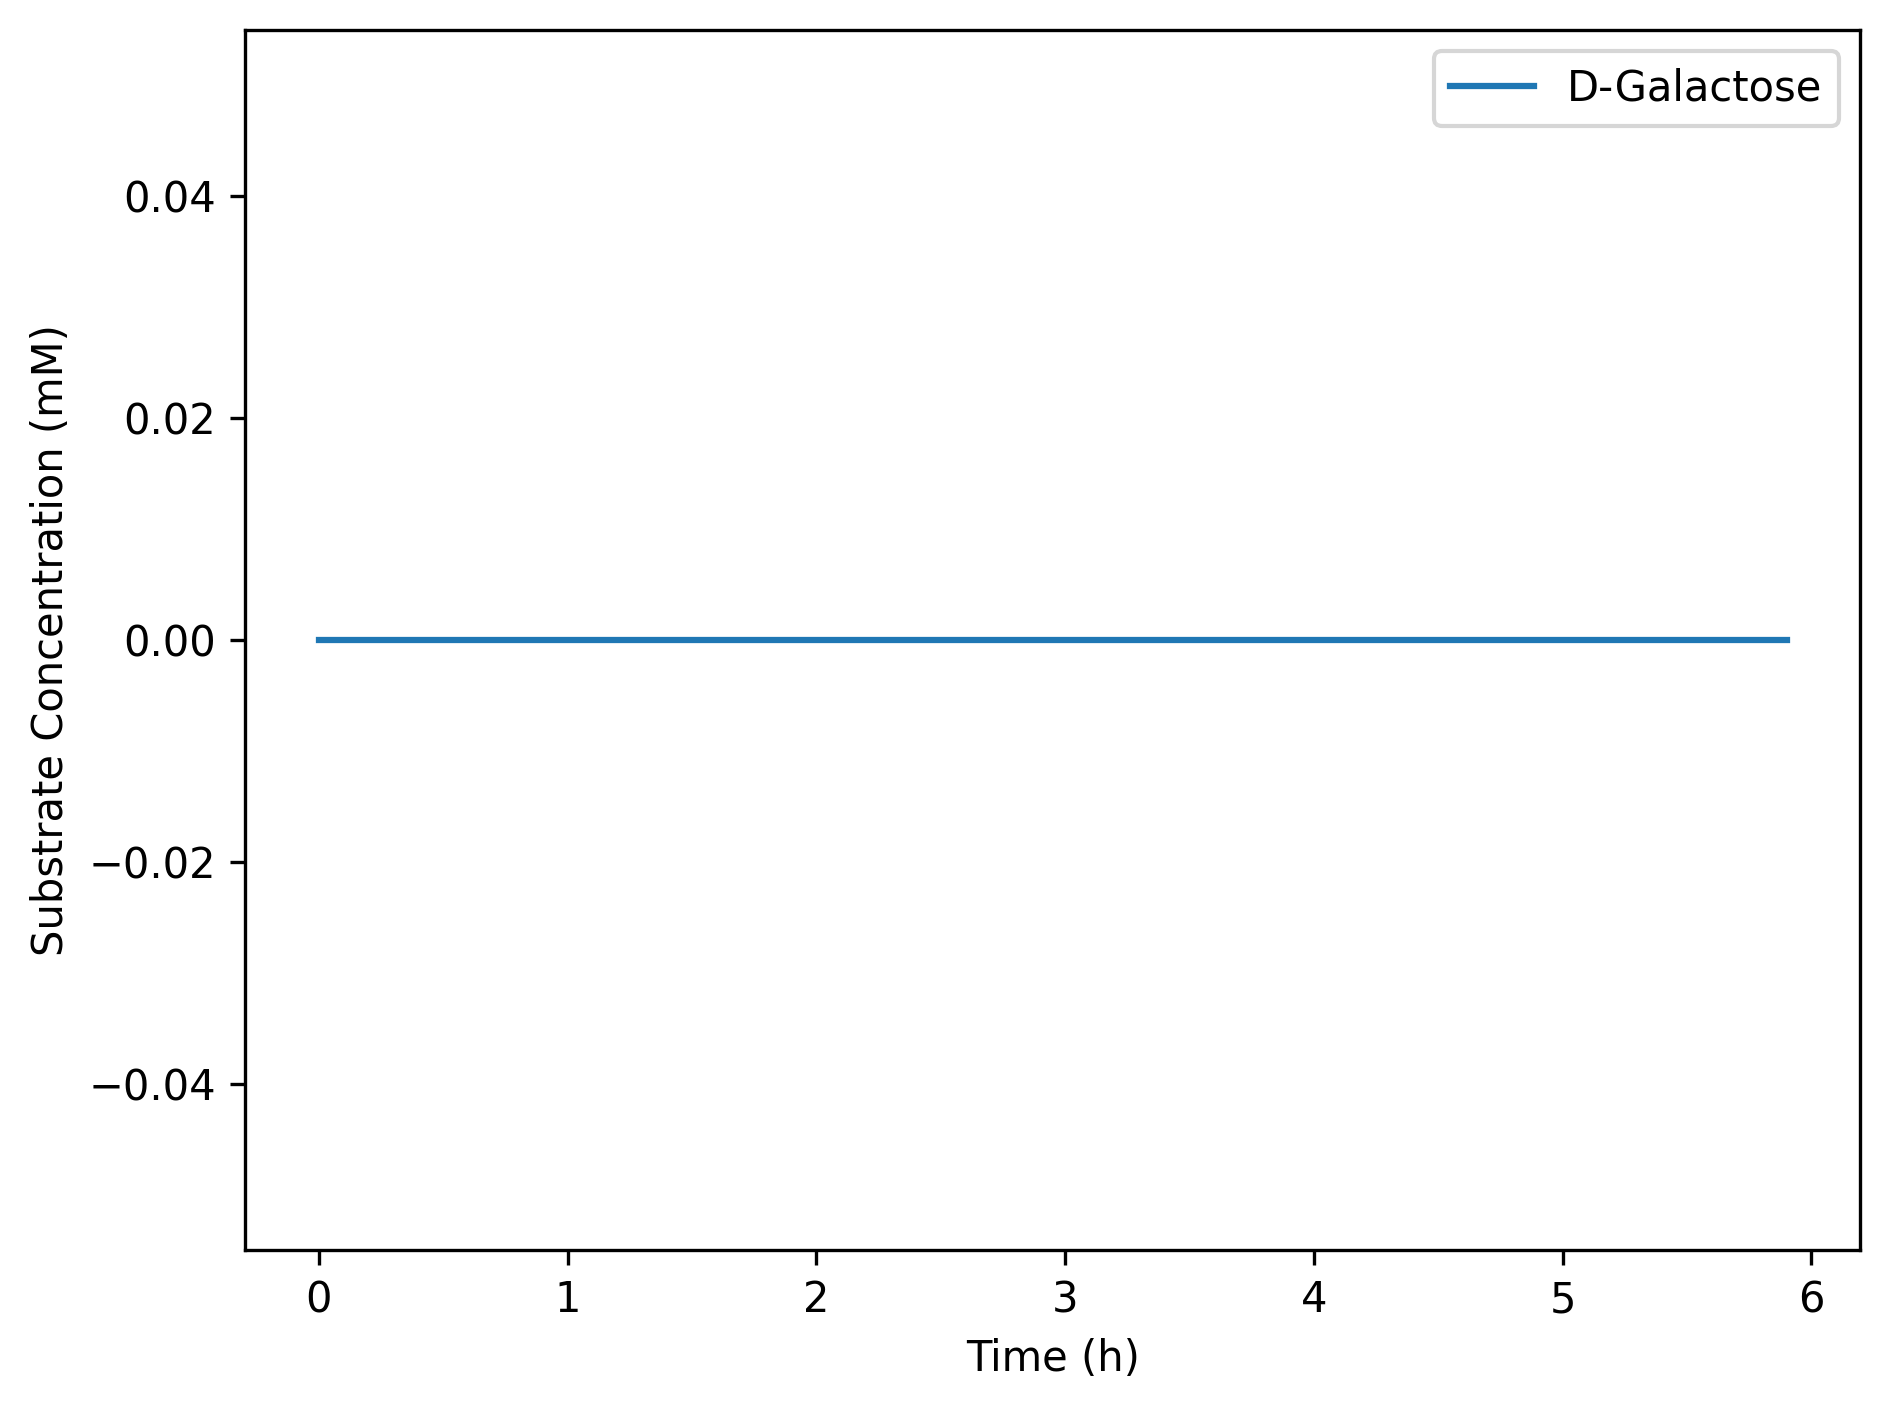

In [169]:
#plote substrates
fig, ax = plt.subplots(dpi=300)
for key, value in env_combined.items():
    if key in ['Lactose C12H22O11', 'D-Galactose']:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time (h)')
plt.ylabel('Substrate Concentration (mM)')
plt.legend()
plt.tight_layout()
plt.show()